Here's the page I found for this data analysis tutorial, I'm basically redoing it to understand the author's approach :  https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-learn-data-science-python-scratch-2/

You'll also find the dataset we use here : https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/

In [100]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#from plotly import __version__
#rom plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#print (__version__) # requires version >= 1.9.0

from IPython.display import display
import plotly.plotly as py1
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
from plotly import tools
from IPython.display import HTML

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [71]:
# path contains \ and it seems like it generates a unicode error. Let's just
# replace backslashes by forward slashes

csv_file = "C:/Users/Lucho/Desktop/Code/DataAnalysis/Loan_Prediction_Problem/train_u6lujuX_CVtuZ9i.csv"

df = pd.read_csv(csv_file)

## Quick Data Exploration

In [72]:
df.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [73]:
df.describe() # get summary of numerical variables
# describe() function would provide count, mean,
# standard deviation (std), min, quartiles and max in its output

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


We can see from here there are some missing values.
- First LoanAmount has (614 - 592) 22 missing values.
- LoanAmount_Term has (614 - 600) 14 missing values.
- Credid_History has (614 - 564) 50 missing values.

Also we can deduce that we only 84% applicants have a credit history. Indeed, the mean of Credit_History is 0.84. Therefore, this column's value can only be 0 or 1 (1 if you have a credit history and 0 if you don't).

As it is said on the site, it's possible to have an idea of a possible skew in the data by comparing the **mean** to the **median** i.e. the 50% figure.

The dataset also contains non-numerical values (e.g. Property_Area, Gender, etc.). We can look at frequency distribution to understand wheter they make sense or not. Let's print the frequency table of Property_Area :

In [74]:
df['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

## Distribution analysis

Let's study distribution of various variables. In the first place, we'll deal with numeric variables such as ApplicantIncome and LoanAmount.
Let's start by plotting the histogram of ApplicantIncome :

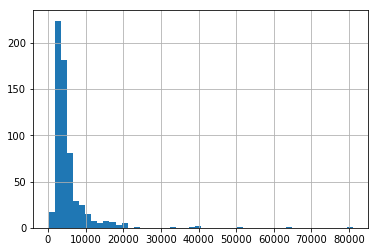

In [75]:
df['ApplicantIncome'].hist(bins=50)

We can see there are few extreme values.

Next, we look at box plots (boîte à moustaches in French) to understand the distributions.

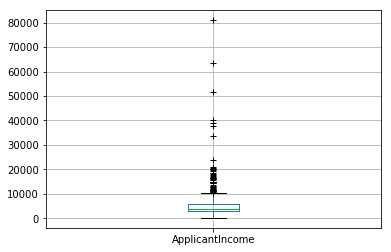

In [76]:
df.boxplot(column='ApplicantIncome', sym="+")

This confirms the presence of outlier (valeur aberrante) and extreme values. It can be explained by the income disparity in the society. Also we're looking at people from different backgrounds. So we're gonna segragate them by Education :

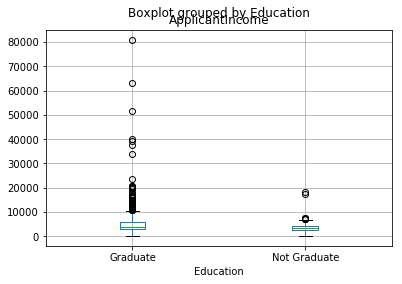

In [77]:
df.boxplot(column='ApplicantIncome', by = 'Education')

We can see means between income of graduates and non-graduates are really close. But people who graduate are more likely to have high and very high incomes.

Now let's look at the histogram and boxplot of LoanAmount :

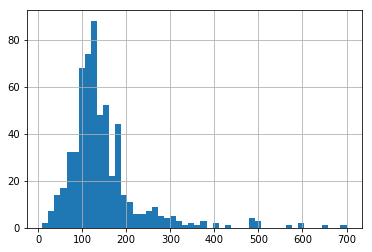

In [78]:
df['LoanAmount'].hist(bins=50)

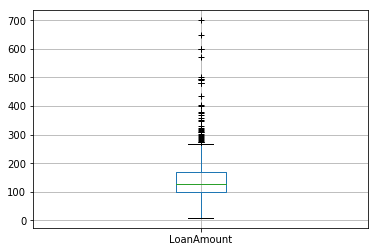

In [79]:
df.boxplot(column='LoanAmount', sym="+")

Also here, there are some extreme value. It will be necessary to do some **data munging** (nettoyage de données) for both ApplicantIncome and LoanAmount.
ApplicantIncome has a few extreme values while LoanAmount has both missing and extreme values, which demands more a deeper understanding.

## Categorical variable analysis

Now that we saw how ApplicantIncome and LoanIncome are distributed, it's time to  look into categorical variables. We will use Excel style pivot table and cross-tabulation. For instance, let us look at the odds of getting a loan based on credit history. This can be done in MS Excel using a pivot table as :

In [80]:
temp1 = df['Credit_History'].value_counts(ascending=True)
temp2 = df.pivot_table(values='Loan_Status',index=['Credit_History'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
print('Frequency Table for Credit History:')
print(temp1)

print('\nProbility of getting loan for each Credit History class:')
print(temp2)

Frequency Table for Credit History:
0.0     89
1.0    475
Name: Credit_History, dtype: int64

Probility of getting loan for each Credit History class:
                Loan_Status
Credit_History             
0.0                0.078652
1.0                0.795789


This prints a similar pivot table like the MS Excel one. We actually can plot this using matplotlib :

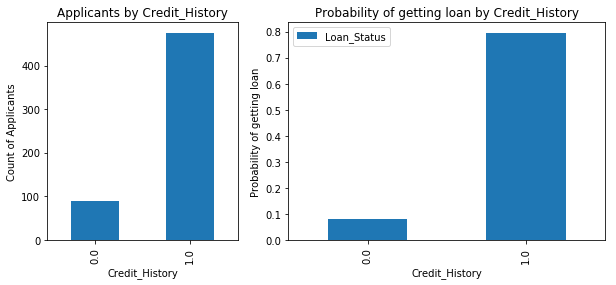

In [81]:
#Code on the tutorial would actually create 3 subplots and would only plot 2 of them, I don't know exactly why but using the
#subplot function seems easier to handle
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,4), gridspec_kw = {'width_ratios':[3, 5]})


ax1.set_xlabel('Credit_History')
ax1.set_ylabel('Count of Applicants')
ax1.set_title('Applicants by Credit_History')
temp1.plot(ax=ax1, kind='bar')
ax2.set_xlabel('Credit_History')
ax2.set_ylabel('Probability of getting loan')
ax2.set_title('Probability of getting loan by Credit_History')
temp2.plot(ax=ax2, kind='bar')

Odds of getting a loan are eight-fold if the applicant has a valid credit history. We could plot the same graphs by Married, Self-Employed, Property_Area, etc.

An another way of visualising these plots is to combine them in a stacked chart :

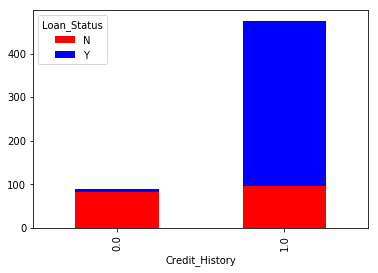

In [82]:
temp3 = pd.crosstab(df['Credit_History'], df['Loan_Status'])
temp3.plot(kind='bar', stacked=True, color=['red', 'blue'], grid=False)

It's interesting to take gender into account :

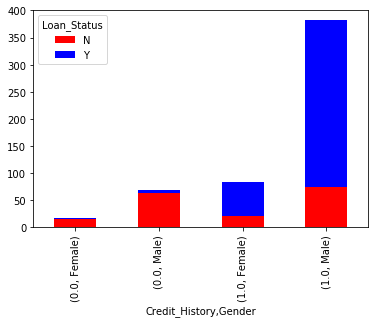

In [83]:
temp3 = pd.crosstab( (df['Credit_History'], df['Gender']), df['Loan_Status'])
temp3.plot(kind='bar', stacked=True, color=['red', 'blue'], grid=False)


## Data Munging in Python : Using Pandas

### Data munging - recap of the need

We quickly found problems in the data when we started exploring it. We need to handle this in order to get the data good enough to create a model out of it. Here are the problems that we encountered :
1. There are missing values in some variables. Based on the amount of missing values and the expected importance of variables, we should estimate those values wisely.
2. Back when we were looking at the distributions, we saw extreme values in ApplicantIncome and LoanAmount at either end. These values seem to make sense, but should be treated appropriately.

Therefore, we should also look at the non-numerical fields e.g. Gender or Education to detect any outlier or useful information.

## Check missing values in the dataset

Let's check the number of missing values (nulls) and NaNs (not a number) in the dataset.

In [109]:
df2 = df.apply(lambda x: sum(x.isnull()),axis=0)
#Since df2 is a series, we extract its values with tolist function
missing_values = df2.tolist()
df2

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

To know if the amount of missing values is significant or not, we can plot in a stacked bar chart both missing and non missing values.

In [110]:
df3 = df.apply(lambda x: sum(x.notnull()),axis=0)
non_missing_values = df3.tolist()
df3

Loan_ID              614
Gender               601
Married              611
Dependents           599
Education            614
Self_Employed        582
ApplicantIncome      614
CoapplicantIncome    614
LoanAmount           592
Loan_Amount_Term     600
Credit_History       564
Property_Area        614
Loan_Status          614
dtype: int64

In [112]:
#We'll use plotly from there, as it seems more efficient, more dynamic and easier to use than matplotlib

names = df2.index.tolist()

trace1 = go.Bar(
    x=names,
    y=missing_values,
    name='Missing values'
)
trace2 = go.Bar(
    x=names,
    y=non_missing_values,
    name='Non null values'
)

data = [trace1, trace2]
layout = go.Layout(
barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

In percentages, this reprents :

In [133]:
# 
missing_ratio = np.divide(missing_values, non_missing_values)

missing_ratio_s = [str(i*100) + ' %' for i in missing_ratio]

pd.Series(missing_ratio_s, names)

Loan_ID                         0.0 %
Gender                2.16306156406 %
Married              0.490998363339 %
Dependents             2.5041736227 %
Education                       0.0 %
Self_Employed         5.49828178694 %
ApplicantIncome                 0.0 %
CoapplicantIncome               0.0 %
LoanAmount            3.71621621622 %
Loan_Amount_Term      2.33333333333 %
Credit_History        8.86524822695 %
Property_Area                   0.0 %
Loan_Status                     0.0 %
dtype: object

Let's see if these rates are significant or not :

In [138]:
y = missing_ratio

trace = go.Box(
    y=y,
    boxpoints='all',
    jitter=0.3,
    pointpos=-1.8,
    boxmean=True
)

data = [trace]
py.iplot(data)

We now know that :
- the average rate of missing values is almost 2%
- the higher amount of missing values is in 'Credit_History' where 8.9% of values are missing